# ECSE 551 — Assignment 1
_Group: Lukas Kuhzarani  •  Kernel: ecse551-a1  •  Random state: 42_


In [27]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris

RANDOM_STATE = 42
pd.set_option("display.precision", 4)


ModuleNotFoundError: No module named 'sklearn'

In [ ]:
# Load Iris dataset
iris = load_iris(as_frame=True)
df_iris = iris.frame.rename(columns=lambda c: c.replace(" (cm)", ""))

# Readable Class names
df_iris["species"] = df_iris["target"].map(dict(enumerate(iris.target_names)))
print("Shape (rows, cols):", df_iris.shape)
df_iris.head()



Shape (rows, cols): (150, 6)
Class counts (by numeric target):
target
0    50
1    50
2    50
Name: count, dtype: int64

Class counts (by species name):
species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64


,sepal length,sepal width,petal length,petal width
count,150.0000,150.0000,150.0000,150.0000
mean,5.8433,3.0573,3.7580,1.1993
std,0.8281,0.4359,1.7653,0.7622
min,4.3000,2.0000,1.0000,0.1000
25%,5.1000,2.8000,1.6000,0.3000
50%,5.8000,3.0000,4.3500,1.3000
75%,6.4000,3.3000,5.1000,1.8000
max,7.9000,4.4000,6.9000,2.5000


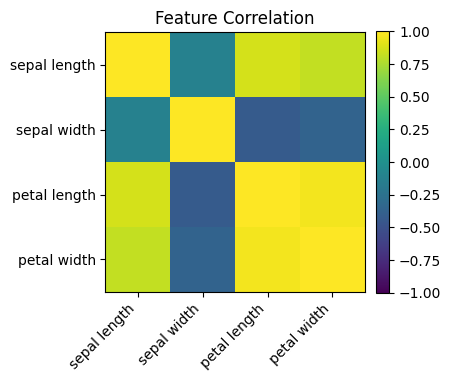

In [ ]:
features = ["sepal length", "sepal width", "petal length", "petal width"]
#Basic statistics
display(df_iris[features].describe())
#Correlation matrix
corr = df_iris[features].corr()

#Heatmap for correlation
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(4.5,4))
im = ax.imshow(corr, vmin=-1, vmax=1)
ax.set_xticks(range(len(features))); ax.set_yticks(range(len(features)))
ax.set_xticklabels(features, rotation=45, ha='right'); ax.set_yticklabels(features)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title("Feature Correlation"); plt.tight_layout(); plt.show()


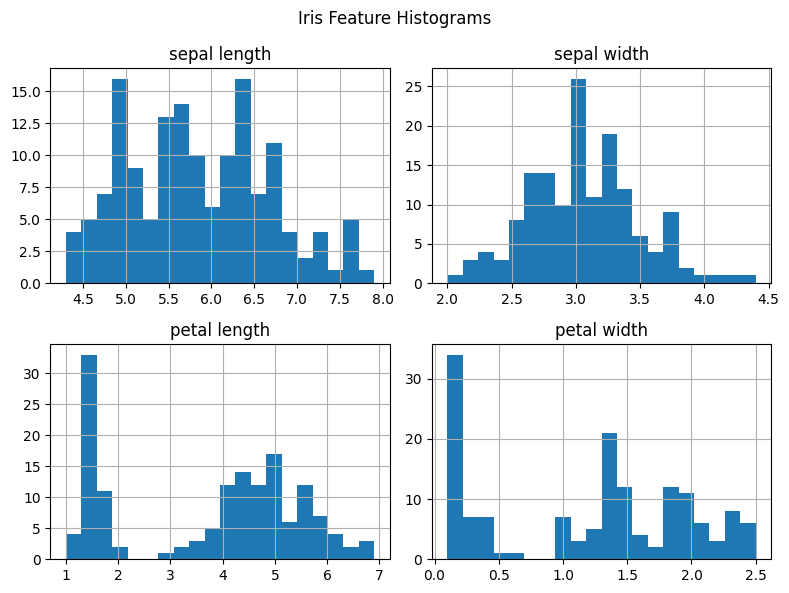

In [ ]:
#Histograms
axes = df_iris[features].hist(bins=20,figsize=(8,6))
plt.suptitle("Iris Feature Histograms"); plt.tight_layout();    plt.show()

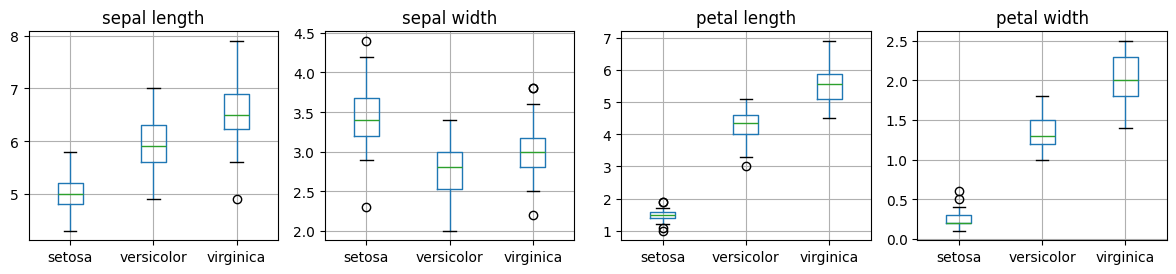

In [ ]:
#Boxplots by Species
fig, axs = plt.subplots(1, 4, figsize=(12,3), sharey=False)
for ax, col in zip(axs, features):
    df_iris.boxplot(column=col, by="species", ax=ax)
    ax.set_title(col); ax.set_xlabel(""); ax.set_ylabel("")
plt.suptitle(""); plt.tight_layout(); plt.show()

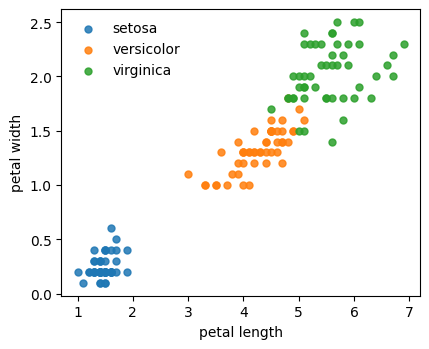

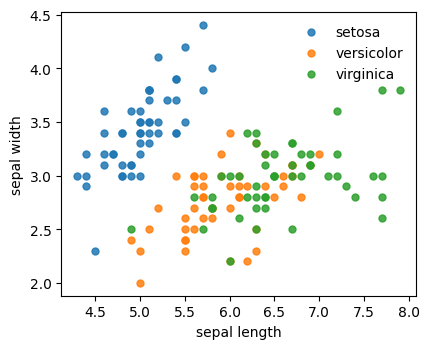

In [ ]:
#Scatter Plots
colors = {"setosa":"tab:blue", "versicolor":"tab:orange", "virginica":"tab:green"}
def cls_scatter(xcol, ycol):
    plt.figure(figsize=(4.4,3.6))
    for sp, sub in df_iris.groupby("species"):
        plt.scatter(sub[xcol],sub[ycol], s=25, alpha=0.85, label=sp, c=colors[sp])
    plt.xlabel(xcol); plt.ylabel(ycol); plt.legend(frameon=False); plt.tight_layout(); plt.show()
cls_scatter("petal length", "petal width")   # most separation
cls_scatter("sepal length",  "sepal width")  # weaker separation

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

x = df_iris[features].to_numpy() # feature matrix as numpy array
y = df_iris["target"].to_numpy() # class labels as integers

#Calculate mew and sigma from training data only
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)
scaler = StandardScaler().fit(X_train)

#Standardization with Training mew and simgma
X_train_s = scaler.transform(X_train) #mean = 0, std = 1
X_test_s  = scaler.transform(X_test)

print("μ≈0:", X_train_s.mean(axis=0))
print("σ≈1:", X_train_s.std(axis=0, ddof=0))


μ≈0: [ 2.38327876e-15 -1.12145742e-15 -1.37456184e-16 -6.97854473e-17]
σ≈1: [1. 1. 1. 1.]


## California Housing Market - Regression Data Analysis
This section focuses on analyzing the housing dataset.

### Section Order Overview
1. Load the data
2. Clean the data
3. Plots:
   - Raw scatter plot, then cleaned scatter plot
   - Raw histogram, then cleaned histogram
   - All other plots (raw data only)

In [69]:
# Fetch and load the housing data
import os
import tarfile
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    with tarfile.open(tgz_path) as housing_tgz:
        housing_tgz.extractall(path=housing_path)

fetch_housing_data()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()

C:\Users\arize\AppData\Local\Temp\ipykernel_14232\840965048.py:18: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tgz.extractall(path=housing_path)


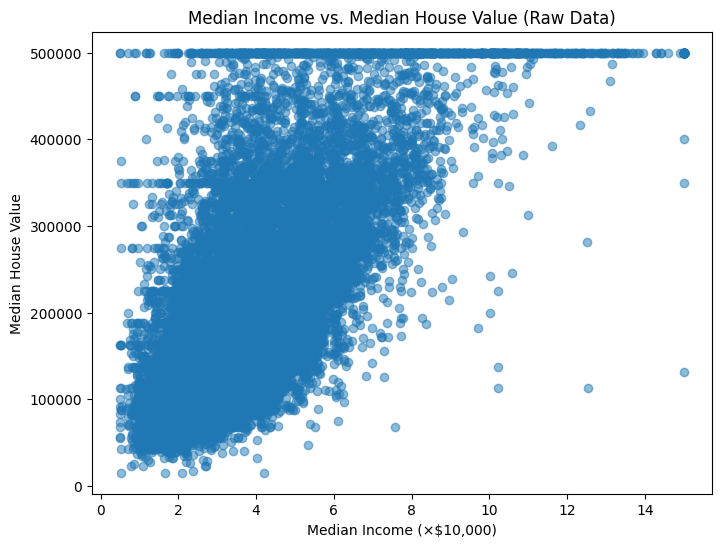

In [70]:
# 1. Scatter plot of raw data (uncleaned)
plt.figure(figsize=(8, 6))
plt.scatter(housing["median_income"], housing["median_house_value"], alpha=0.5)
plt.title("Median Income vs. Median House Value (Raw Data)")
plt.xlabel("Median Income (×$10,000)")
plt.ylabel("Median House Value")
plt.show()

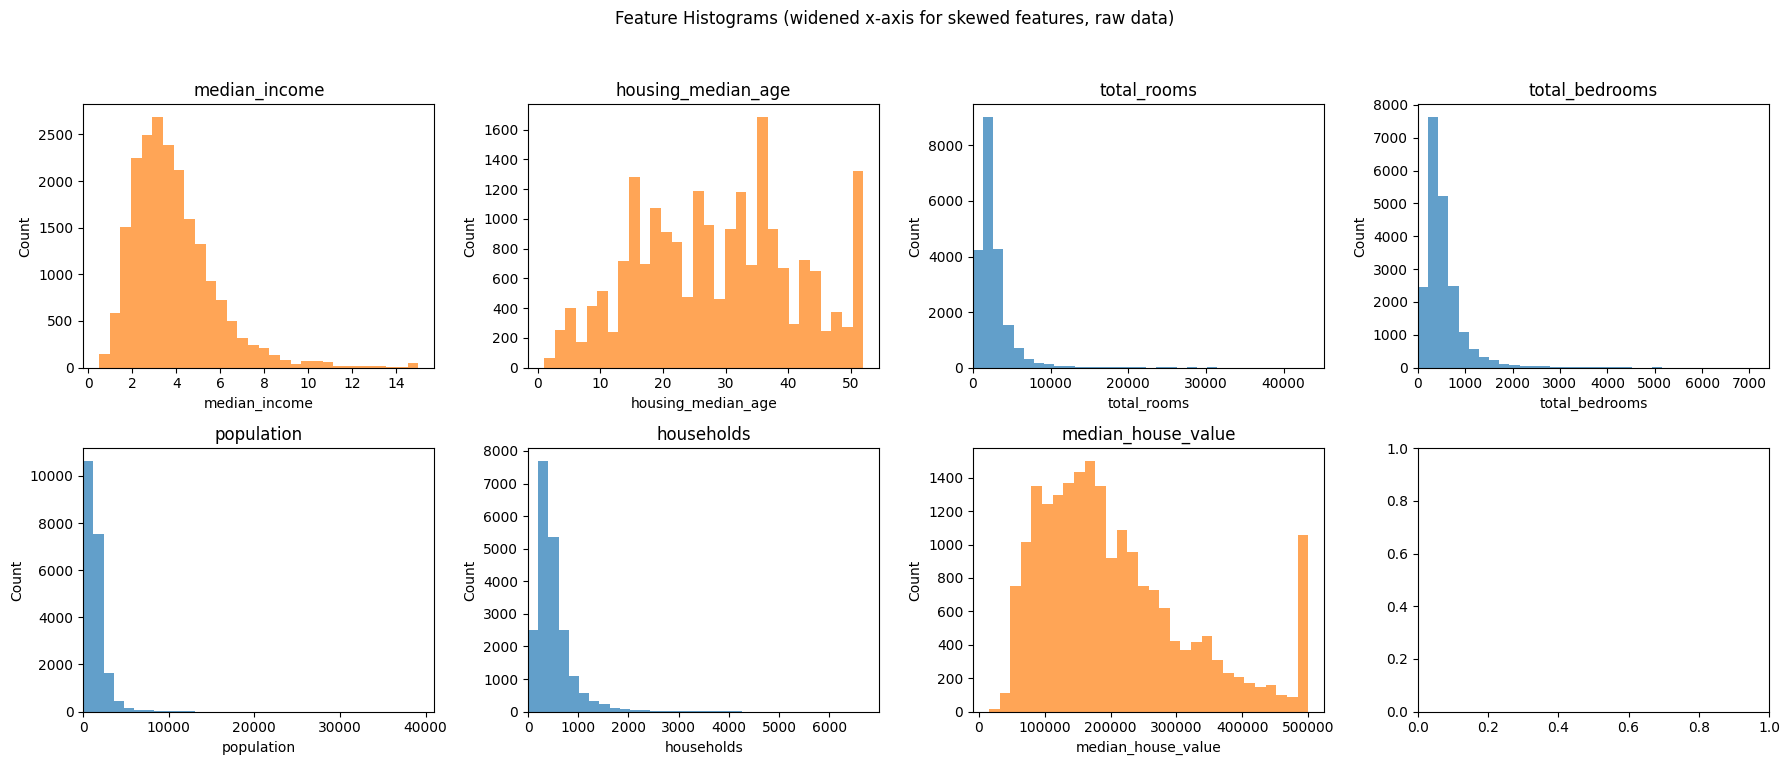

In [71]:
# Histograms for selected features with axis labels and widened x-axis for skewed features (raw data)
import numpy as np
hist_features = ["median_income", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_house_value"]
skewed = ["total_rooms", "total_bedrooms", "population", "households"]
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
for i, feature in enumerate(hist_features):
    ax = axes[i // 4, i % 4]
    data = housing[feature]
    ax.hist(data, bins=30, color='tab:blue' if feature in skewed else 'tab:orange', alpha=0.7)
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')
    ax.set_title(feature)
    if feature in skewed:
        max_val = data.max()
        ax.set_xlim([0, max_val * 1.15])
fig.suptitle('Feature Histograms (widened x-axis for skewed features, raw data)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [72]:
# Remove rows where median_house_value is capped at $500,000
housing_clean = housing[housing["median_house_value"] < 500000].copy()
print(f"Rows before removal: {housing.shape[0]}")
print(f"Rows after removal: {housing_clean.shape[0]}")

# Further cleaning: keep rows within 3 standard deviations for selected features
features_to_filter = ["median_income", "total_rooms", "total_bedrooms", "population", "households"]
for feature in features_to_filter:
    mean = housing_clean[feature].mean()
    std = housing_clean[feature].std()
    lower = mean - 3 * std
    upper = mean + 3 * std
    before = housing_clean.shape[0]
    housing_clean = housing_clean[(housing_clean[feature] >= lower) & (housing_clean[feature] <= upper)]
    after = housing_clean.shape[0]
    print(f"{feature}: kept rows within 3 std ({before} → {after})")

Rows before removal: 20640
Rows after removal: 19648
median_income: kept rows within 3 std (19648 → 19492)
total_rooms: kept rows within 3 std (19492 → 19140)
total_bedrooms: kept rows within 3 std (19140 → 18605)
population: kept rows within 3 std (18605 → 18347)
households: kept rows within 3 std (18347 → 18143)


In [73]:
# Create raw_zeros_removed: replace zero values in feature columns with column mean
raw_features = ["median_income", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households"]
raw_zeros_removed = housing.copy()
for col in raw_features:
    mean_val = raw_zeros_removed[col].replace(0, np.nan).mean()
    raw_zeros_removed[col] = raw_zeros_removed[col].replace(0, mean_val)
print("Zero values replaced by column mean in raw_zeros_removed.")

Zero values replaced by column mean in raw_zeros_removed.


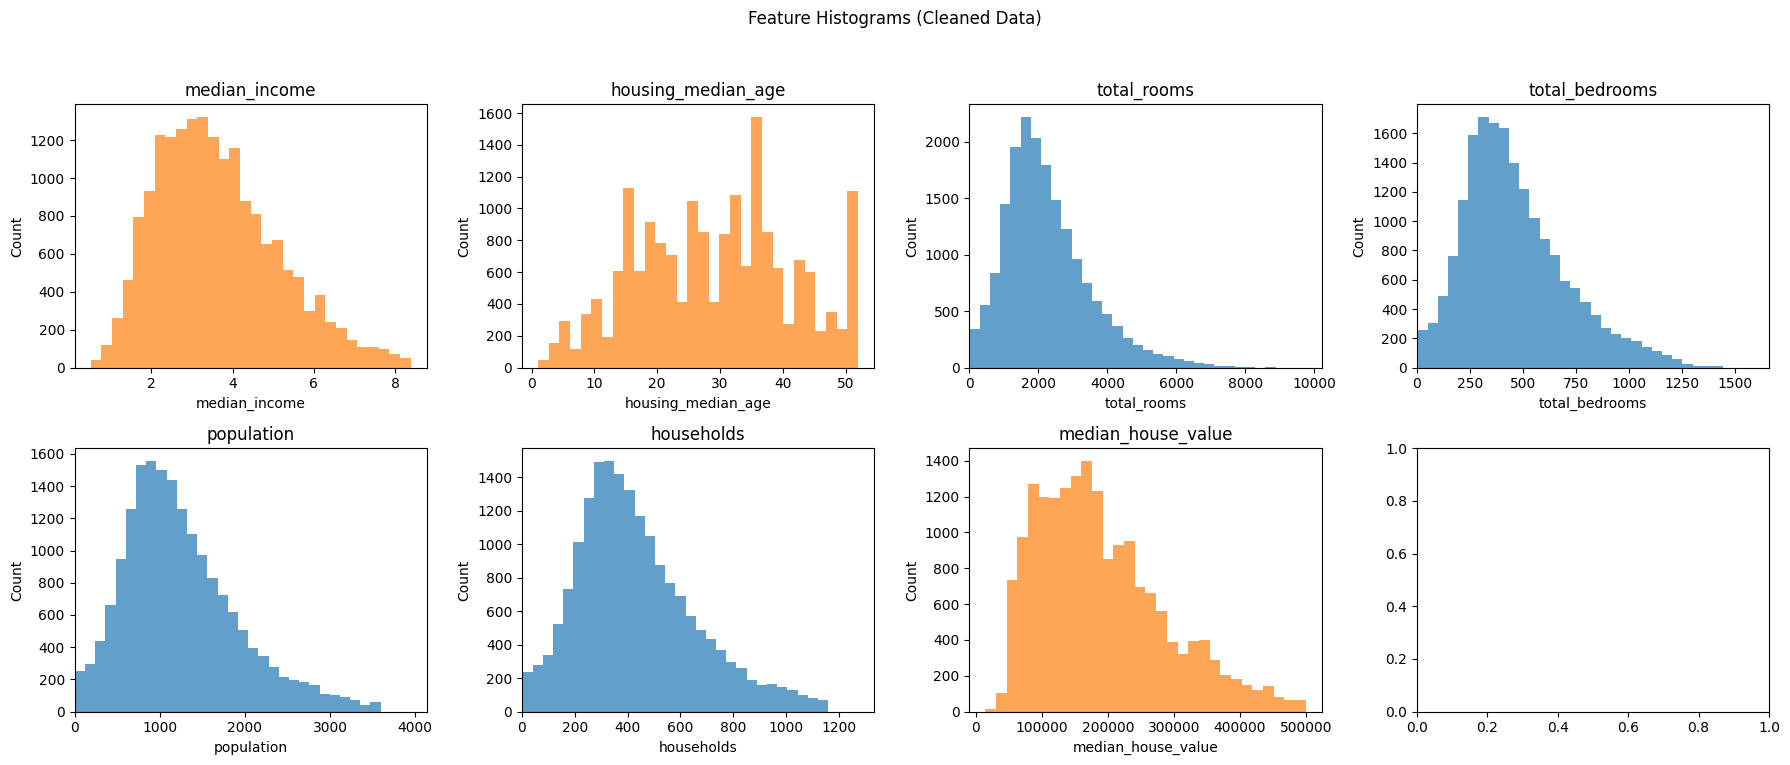

In [74]:
# Histograms for selected features (cleaned data)
hist_features = ["median_income", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_house_value"]
skewed = ["total_rooms", "total_bedrooms", "population", "households"]
import numpy as np
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
for i, feature in enumerate(hist_features):
    ax = axes[i // 4, i % 4]
    data = housing_clean[feature]
    ax.hist(data, bins=30, color='tab:blue' if feature in skewed else 'tab:orange', alpha=0.7)
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')
    ax.set_title(feature)
    if feature in skewed:
        max_val = data.max()
        ax.set_xlim([0, max_val * 1.15])
fig.suptitle('Feature Histograms (Cleaned Data)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

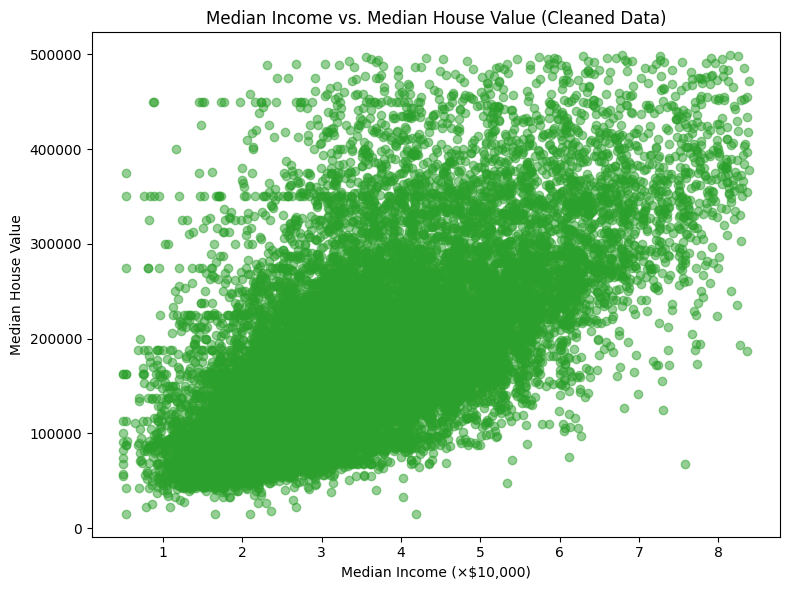

In [75]:
# Scatter plot of median income vs. median house value (cleaned data)
plt.figure(figsize=(8, 6))
plt.scatter(housing_clean["median_income"], housing_clean["median_house_value"], alpha=0.5, color='tab:green')
plt.title("Median Income vs. Median House Value (Cleaned Data)")
plt.xlabel("Median Income (×$10,000)")
plt.ylabel("Median House Value")
plt.tight_layout()
plt.show()

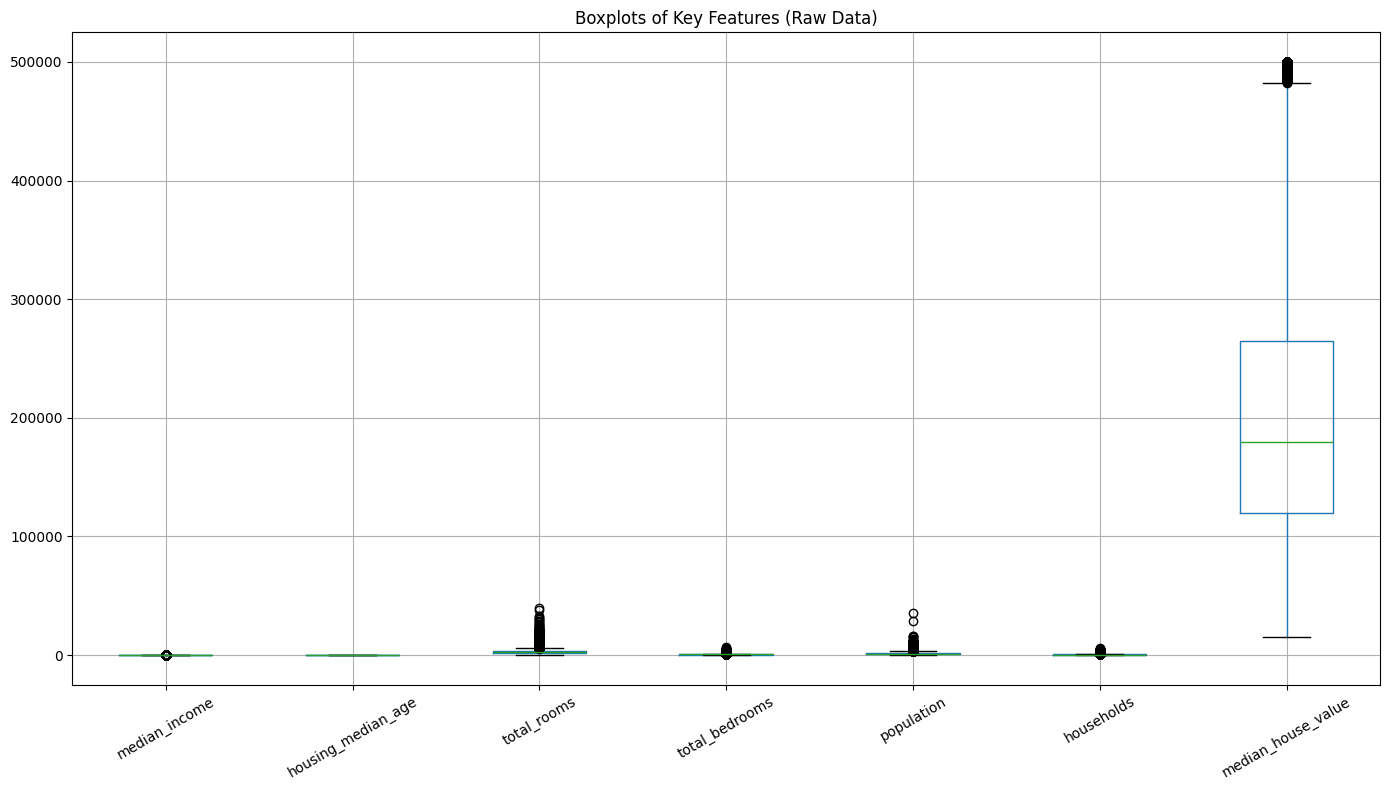

In [76]:
# Boxplots for selected features (raw data)
box_features = ["median_income", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_house_value"]
plt.figure(figsize=(14,8))
housing[box_features].boxplot()
plt.title("Boxplots of Key Features (Raw Data)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

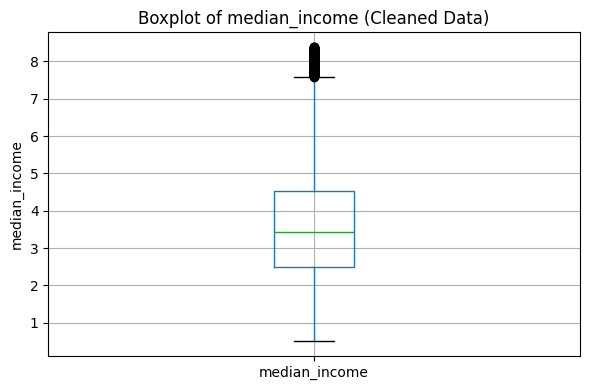

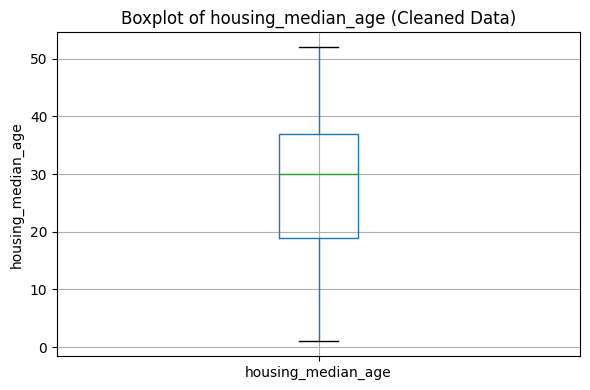

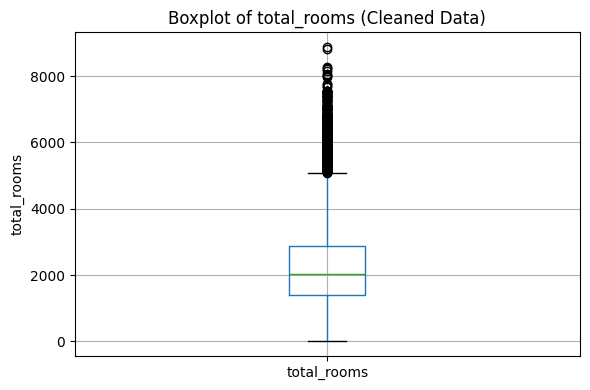

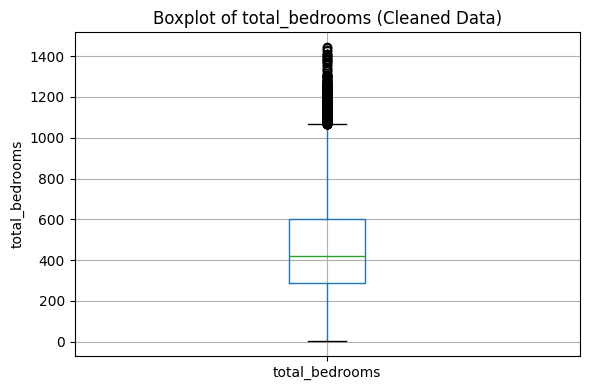

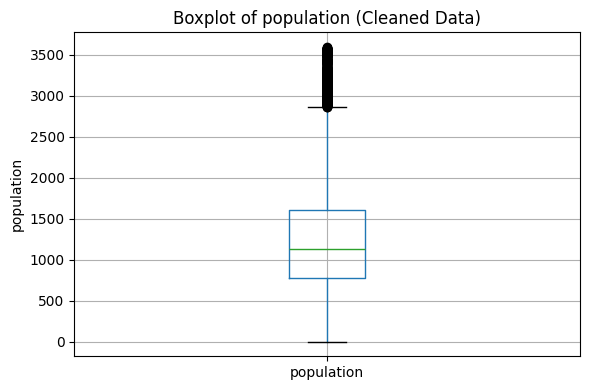

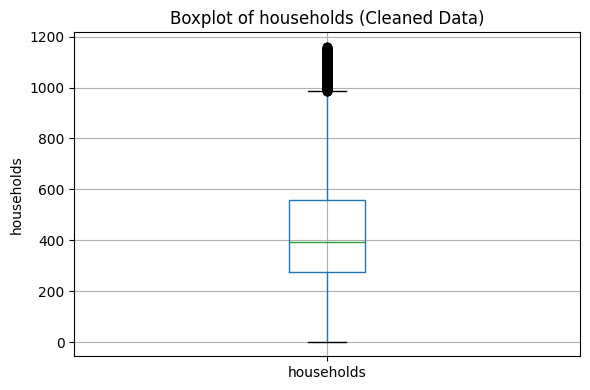

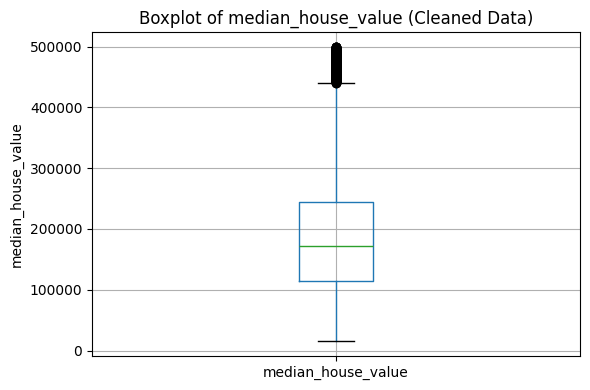

In [77]:
# Individual boxplots for each feature (cleaned data)
cleaned_features = ["median_income", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_house_value"]
for feature in cleaned_features:
    plt.figure(figsize=(6, 4))
    housing_clean.boxplot(column=feature)
    plt.title(f"Boxplot of {feature} (Cleaned Data)")
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()

### Further Outlier Removal Using IQR (Boxplot-Based Cleaning)
To further clean the data, we remove outliers beyond 1.5 × IQR from the first and third quartiles for each main feature. This step targets outliers visible in the boxplots and helps the model focus on the typical case.

In [78]:
# Remove outliers using IQR for each main feature (boxplot-based cleaning)
iqr_features = ["median_income", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_house_value"]
housing_box_clean = housing_clean.copy()
for feature in iqr_features:
    Q1 = housing_box_clean[feature].quantile(0.25)
    Q3 = housing_box_clean[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    before = housing_box_clean.shape[0]
    housing_box_clean = housing_box_clean[(housing_box_clean[feature] >= lower) & (housing_box_clean[feature] <= upper)]
    after = housing_box_clean.shape[0]
    print(f"{feature}: kept rows within 1.5 × IQR ({before} → {after})")

median_income: kept rows within 1.5 × IQR (18143 → 17924)
housing_median_age: kept rows within 1.5 × IQR (17924 → 17924)
total_rooms: kept rows within 1.5 × IQR (17924 → 17349)
total_bedrooms: kept rows within 1.5 × IQR (17349 → 17042)
population: kept rows within 1.5 × IQR (17042 → 16686)
households: kept rows within 1.5 × IQR (16686 → 16596)
median_house_value: kept rows within 1.5 × IQR (16596 → 16293)


### Boxplots for Key Features (Final Cleaned Data)
Below is a box and whisker plot for each main feature using the final cleaned data (`housing_box_clean`). This shows the distribution after all outlier removal steps.

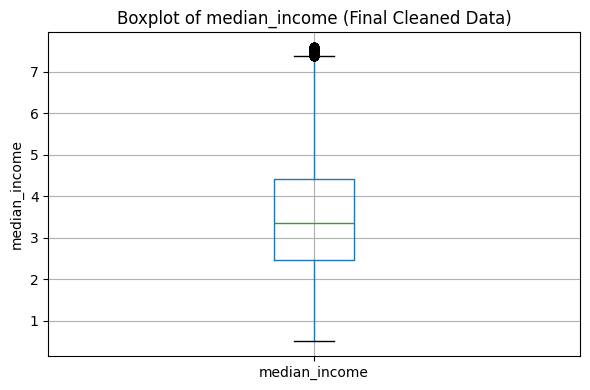

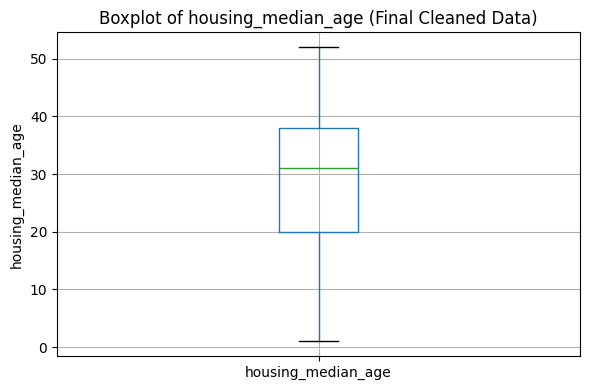

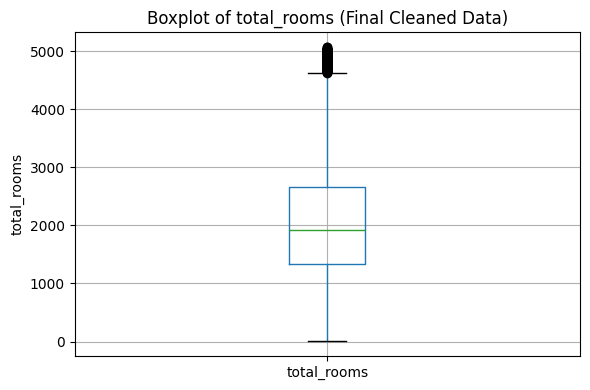

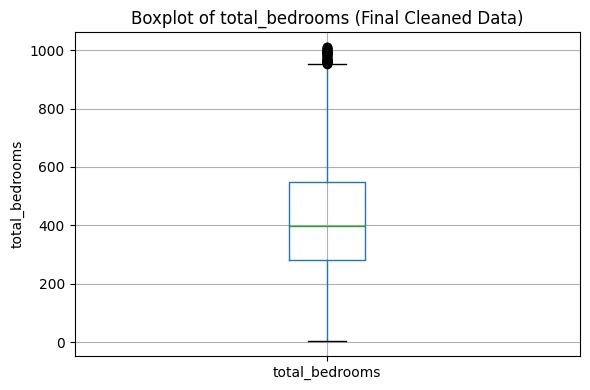

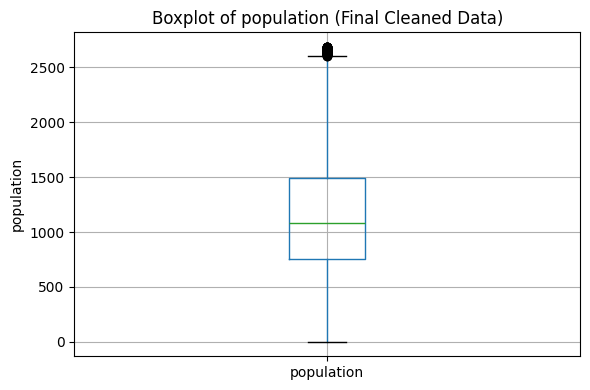

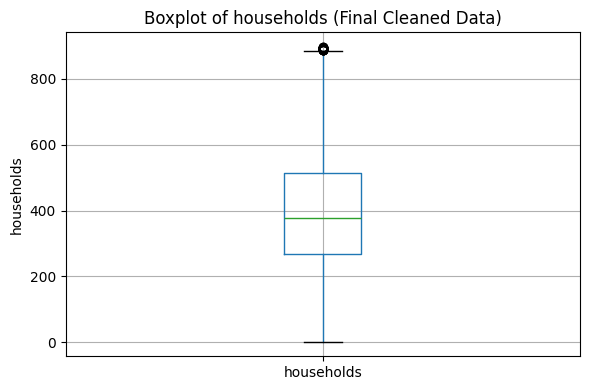

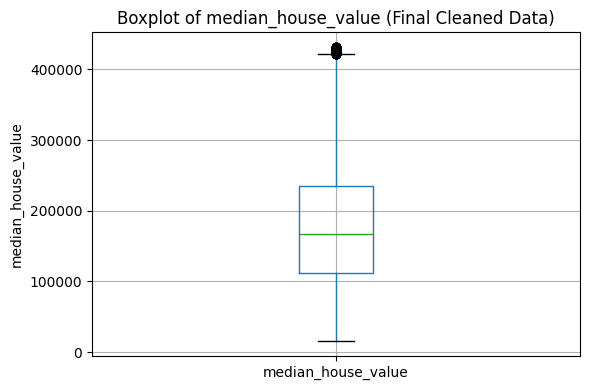

In [79]:
# Individual boxplots for each feature (final cleaned data)
final_features = ["median_income", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_house_value"]
for feature in final_features:
    plt.figure(figsize=(6, 4))
    housing_box_clean.boxplot(column=feature)
    plt.title(f"Boxplot of {feature} (Final Cleaned Data)")
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()

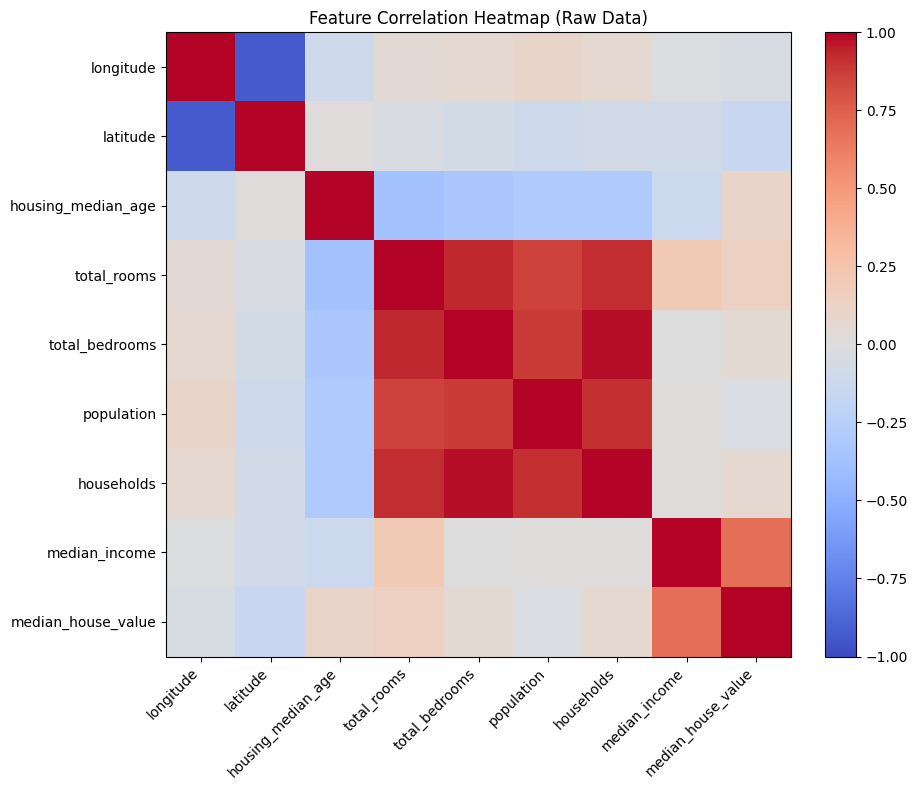

In [80]:
# Correlation heatmap for numeric features (raw data)
corr = housing.corr(numeric_only=True)
plt.figure(figsize=(10,8))
plt.imshow(corr, vmin=-1, vmax=1, cmap='coolwarm')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='right')
plt.yticks(range(len(corr.index)), corr.index)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("Feature Correlation Heatmap (Raw Data)")
plt.tight_layout()
plt.show()

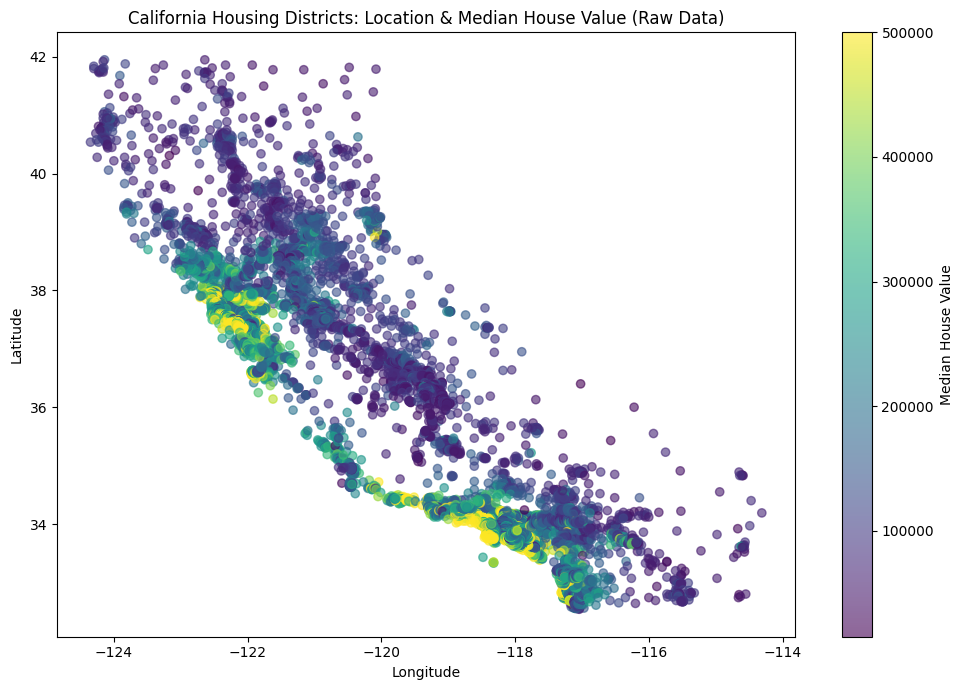

In [81]:
# Geographical scatter plot: longitude vs latitude, colored by median house value (raw data)
plt.figure(figsize=(10,7))
plt.scatter(housing["longitude"], housing["latitude"], c=housing["median_house_value"], cmap="viridis", alpha=0.6)
plt.colorbar(label="Median House Value")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("California Housing Districts: Location & Median House Value (Raw Data)")
plt.tight_layout()
plt.show()

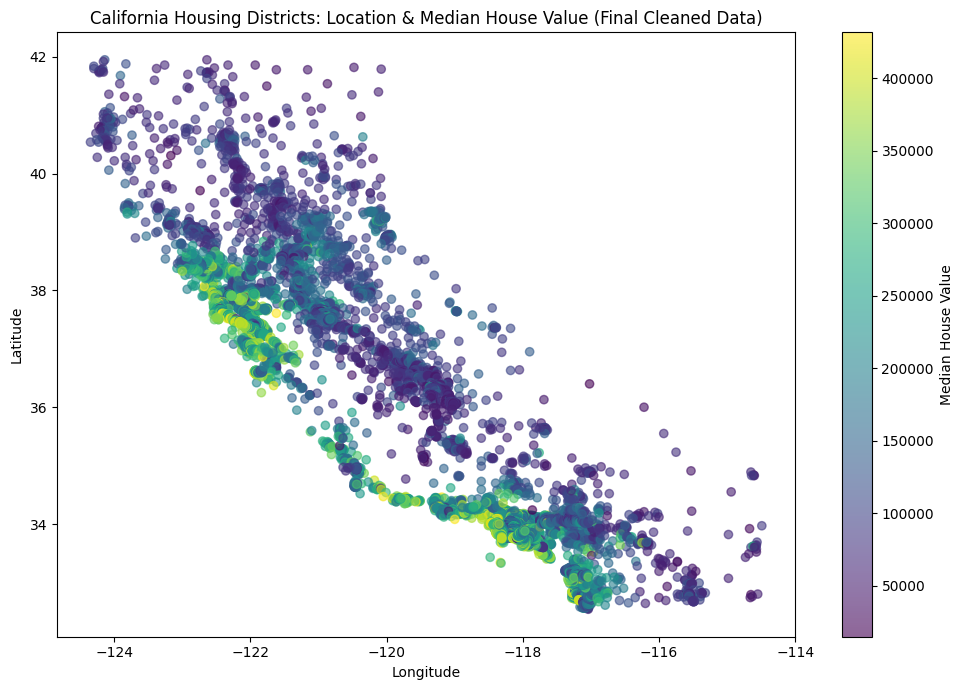

In [82]:
# Geographical scatter plot: longitude vs latitude, colored by median house value (final cleaned data)
plt.figure(figsize=(10,7))
plt.scatter(housing_box_clean["longitude"], housing_box_clean["latitude"], c=housing_box_clean["median_house_value"], cmap="viridis", alpha=0.6)
plt.colorbar(label="Median House Value")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("California Housing Districts: Location & Median House Value (Final Cleaned Data)")
plt.tight_layout()
plt.show()

In [83]:
# Ridge Regression implemented from scratch using numpy
import numpy as np

class RidgeRegression():
    def __init__(self, learning_rate, iterations, penalty):
        # initialize parameters
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.penalty = penalty
        self.weights = None
        self.bias = None

    def fit(self, X, Y):
        # training loop
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.iterations):
            # prediction
            y_pred = np.dot(X, self.weights) + self.bias
            # gradients
            dw = (1/n_samples) * (np.dot(X.T, (y_pred - Y)) + self.penalty * self.weights)
            db = (1/n_samples) * np.sum(y_pred - Y)
            # update weights
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def update_weights(self):
        # weight update rule (already included in fit)
        pass  # The update is performed inside the fit method

    def predict(self, X):
        # prediction rule
        return np.dot(X, self.weights) + self.bias


In [84]:
# Apply Ridge Regression to California Housing data (final cleaned)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Features and target
features = ["median_income", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households"]
target = "median_house_value"

X = housing_box_clean[features].values
Y = housing_box_clean[target].values

# Train/test split (70/30, random_state=42)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Standardize features (fit on train, transform both)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Try several penalty values to analyze effect
penalties = [0, 10, 100]
results = []
for penalty in penalties:
    model = RidgeRegression(learning_rate=0.01, iterations=1000, penalty=penalty)
    model.fit(X_train_scaled, Y_train)
    Y_pred = model.predict(X_test_scaled)
    mse = np.mean((Y_test - Y_pred) ** 2)
    results.append({"penalty": penalty, "mse": mse, "weights": model.weights.copy()})
    print(f"Penalty: {penalty}, MSE: {mse:.2f}")
    print(f"Coefficients: {model.weights}")

# Display summary of results
import pandas as pd
summary = pd.DataFrame(results)
display(summary)

Penalty: 0, MSE: 3771261652.85
Coefficients: [ 63044.75658215  18914.44092301 -18419.52696321  22263.77370047
 -23456.70070644  25269.17646587]
Penalty: 10, MSE: 3772258469.17
Coefficients: [ 62957.58108318  18892.2699003  -18302.2984951   22177.08658144
 -23386.73422865  25179.23997397]
Penalty: 100, MSE: 3781544052.30
Coefficients: [ 62186.54026052  18694.32592286 -17277.66779316  21417.70728813
 -22771.72695529  24390.97249915]


,penalty,mse,weights
0,0,3.771262e+09,"[63044.756582149996, 18914.440923008773, -1841..."
1,10,3.772258e+09,"[62957.58108318272, 18892.2699002979, -18302.2..."
2,100,3.781544e+09,"[62186.54026052235, 18694.325922857373, -17277..."


Penalty: 0, MSE: 3771261652.85, RMSE: 61410.60, R^2: 0.5078
Coefficients: [ 63044.75658215  18914.44092301 -18419.52696321  22263.77370047
 -23456.70070644  25269.17646587]
Penalty: 1, MSE: 3771361004.40, RMSE: 61411.41, R^2: 0.5078
Coefficients: [ 63036.02525539  18912.22222173 -18407.77304065  22255.08375325
 -23449.68908362  25260.16122063]
Penalty: 5, MSE: 3771759145.96, RMSE: 61414.65, R^2: 0.5077
Coefficients: [ 63001.13059074  18903.35097039 -18360.8264818   22220.37120307
 -23421.67590259  25224.14828051]
Penalty: 10, MSE: 3772258469.17, RMSE: 61418.71, R^2: 0.5076
Coefficients: [ 62957.58108318  18892.2699003  -18302.2984951   22177.08658144
 -23386.73422865  25179.23997397]
Penalty: 1, MSE: 3771361004.40, RMSE: 61411.41, R^2: 0.5078
Coefficients: [ 63036.02525539  18912.22222173 -18407.77304065  22255.08375325
 -23449.68908362  25260.16122063]
Penalty: 5, MSE: 3771759145.96, RMSE: 61414.65, R^2: 0.5077
Coefficients: [ 63001.13059074  18903.35097039 -18360.8264818   22220.3712

,penalty,mse,rmse,r2,weights
0,0,3.771262e+09,61410.598864,0.507778,"[63044.756582149996, 18914.440923008773, -1841..."
1,1,3.771361e+09,61411.407771,0.507765,"[63036.025255391054, 18912.222221734635, -1840..."
2,5,3.771759e+09,61414.649278,0.507713,"[63001.13059074235, 18903.35097038544, -18360...."
3,10,3.772258e+09,61418.714324,0.507648,"[62957.58108318272, 18892.2699002979, -18302.2..."
4,25,3.773767e+09,61430.996109,0.507451,"[62827.38943600679, 18859.079954384913, -18127..."
5,50,3.776317e+09,61451.747851,0.507118,"[62611.91420631482, 18803.940736568762, -17840..."
6,100,3.781544e+09,61494.260320,0.506436,"[62186.54026052235, 18694.325922857373, -17277..."
7,250,3.798129e+09,61628.965986,0.504271,"[60953.313123438835, 18370.758385814617, -1568..."
8,500,3.828171e+09,61872.211497,0.500350,"[59030.282129462976, 17848.824571276844, -1332..."
9,1000,3.893819e+09,62400.471676,0.491782,"[55611.491477148724, 16867.814809145646, -9490..."


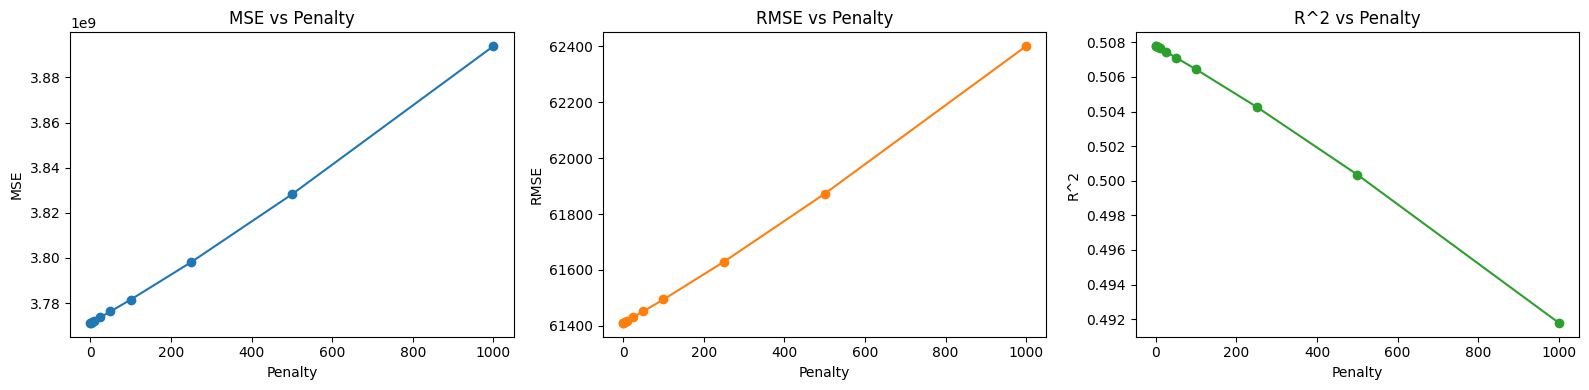

In [85]:
# Extended Ridge Regression analysis: more penalties, RMSE, R^2
import matplotlib.pyplot as plt

penalties = [0, 1, 5, 10, 25, 50, 100, 250, 500, 1000]
results = []
for penalty in penalties:
    model = RidgeRegression(learning_rate=0.01, iterations=1000, penalty=penalty)
    model.fit(X_train_scaled, Y_train)
    Y_pred = model.predict(X_test_scaled)
    mse = np.mean((Y_test - Y_pred) ** 2)
    rmse = np.sqrt(mse)
    r2 = 1 - mse / np.var(Y_test)
    results.append({"penalty": penalty, "mse": mse, "rmse": rmse, "r2": r2, "weights": model.weights.copy()})
    print(f"Penalty: {penalty}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, R^2: {r2:.4f}")
    print(f"Coefficients: {model.weights}")

# Display summary of results
import pandas as pd
summary = pd.DataFrame(results)
display(summary)

# Plot MSE, RMSE, R^2 vs penalty
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].plot(summary["penalty"], summary["mse"], marker='o')
axs[0].set_title("MSE vs Penalty")
axs[0].set_xlabel("Penalty")
axs[0].set_ylabel("MSE")
axs[1].plot(summary["penalty"], summary["rmse"], marker='o', color='tab:orange')
axs[1].set_title("RMSE vs Penalty")
axs[1].set_xlabel("Penalty")
axs[1].set_ylabel("RMSE")
axs[2].plot(summary["penalty"], summary["r2"], marker='o', color='tab:green')
axs[2].set_title("R^2 vs Penalty")
axs[2].set_xlabel("Penalty")
axs[2].set_ylabel("R^2")
plt.tight_layout()
plt.show()

In [86]:
# Compare RMSE to standard deviation of target (Y_test)
std_y_test = np.std(Y_test)
print(f"Standard deviation of Y_test: {std_y_test:.2f}")
print("\nRMSE / std(Y_test) for each penalty:")
for i, penalty in enumerate(summary["penalty"]):
    rmse = summary.loc[i, "rmse"]
    ratio = rmse / std_y_test
    print(f"Penalty: {penalty:>5}, RMSE: {rmse:.2f}, Ratio: {ratio:.3f}")

Standard deviation of Y_test: 87531.17

RMSE / std(Y_test) for each penalty:
Penalty:     0, RMSE: 61410.60, Ratio: 0.702
Penalty:     1, RMSE: 61411.41, Ratio: 0.702
Penalty:     5, RMSE: 61414.65, Ratio: 0.702
Penalty:    10, RMSE: 61418.71, Ratio: 0.702
Penalty:    25, RMSE: 61431.00, Ratio: 0.702
Penalty:    50, RMSE: 61451.75, Ratio: 0.702
Penalty:   100, RMSE: 61494.26, Ratio: 0.703
Penalty:   250, RMSE: 61628.97, Ratio: 0.704
Penalty:   500, RMSE: 61872.21, Ratio: 0.707
Penalty:  1000, RMSE: 62400.47, Ratio: 0.713


In [87]:
# Compare Ridge Regression performance on raw_zeros_removed, housing_clean, and housing_box_clean data
def ridge_regression_results(data, features, target, penalties):
    X = data[features].values
    Y = data[target].values
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    std_y_test = np.std(Y_test)
    print(f"Standard deviation of Y_test: {std_y_test:.2f}")
    print("Penalty | RMSE | RMSE/std(Y_test)")
    for penalty in penalties:
        model = RidgeRegression(learning_rate=0.01, iterations=1000, penalty=penalty)
        model.fit(X_train_scaled, Y_train)
        Y_pred = model.predict(X_test_scaled)
        mse = np.mean((Y_test - Y_pred) ** 2)
        rmse = np.sqrt(mse)
        ratio = rmse / std_y_test
        print(f"{penalty:>6} | {rmse:>7.2f} | {ratio:>10.3f}")
    print()

features = ["median_income", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households"]
target = "median_house_value"
penalties = [0, 1, 5, 10, 25, 50, 100, 250, 500, 1000]

print("--- Raw Data ---")
ridge_regression_results(raw_zeros_removed, features, target, penalties)

print("--- housing_clean Data ---")
ridge_regression_results(housing_clean, features, target, penalties)

print("--- housing_box_clean Data (already shown above) ---")
ridge_regression_results(housing_box_clean, features, target, penalties)

--- Raw Data ---
Standard deviation of Y_test: 114566.14
Penalty | RMSE | RMSE/std(Y_test)
     0 |     nan |        nan
     1 |     nan |        nan
     0 |     nan |        nan
     1 |     nan |        nan
     5 |     nan |        nan
    10 |     nan |        nan
     5 |     nan |        nan
    10 |     nan |        nan
    25 |     nan |        nan
    25 |     nan |        nan
    50 |     nan |        nan
   100 |     nan |        nan
    50 |     nan |        nan
   100 |     nan |        nan
   250 |     nan |        nan
   250 |     nan |        nan
   500 |     nan |        nan
  1000 |     nan |        nan

--- housing_clean Data ---
Standard deviation of Y_test: 96880.07
Penalty | RMSE | RMSE/std(Y_test)
   500 |     nan |        nan
  1000 |     nan |        nan

--- housing_clean Data ---
Standard deviation of Y_test: 96880.07
Penalty | RMSE | RMSE/std(Y_test)
     0 | 67242.32 |      0.694
     1 | 67243.04 |      0.694
     0 | 67242.32 |      0.694
     1 | 67243

In [ ]:
# LASSO Regression implemented from scratch using numpy
import numpy as np
class LassoRegression():
    def __init__(self, learning_rate, iterations, penalty):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.penalty = penalty
        self.weights = None
        self.bias = None
    def fit(self, X, Y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        for _ in range(self.iterations):
            y_pred = np.dot(X, self.weights) + self.bias
            dw = (1/n_samples) * (np.dot(X.T, (y_pred - Y)))
            # L1 penalty gradient (subgradient)
            dw += self.penalty * np.sign(self.weights)
            db = (1/n_samples) * np.sum(y_pred - Y)
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

# Apply LASSO Regression to housing_box_clean data
features = ["median_income", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households"]
target = "median_house_value"
X = housing_box_clean[features].values
Y = housing_box_clean[target].values
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

penalties = [0, 1, 5, 10, 25, 50, 100, 250, 500, 1000]
results = []
for penalty in penalties:
    model = LassoRegression(learning_rate=0.01, iterations=1000, penalty=penalty)
    model.fit(X_train_scaled, Y_train)
    Y_pred = model.predict(X_test_scaled)
    mse = np.mean((Y_test - Y_pred) ** 2)
    rmse = np.sqrt(mse)
    r2 = 1 - mse / np.var(Y_test)
    results.append({"penalty": penalty, "mse": mse, "rmse": rmse, "r2": r2, "weights": model.weights.copy()})
    print(f"Penalty: {penalty}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, R^2: {r2:.4f}")
    print(f"Coefficients: {model.weights}")

import pandas as pd
summary_lasso = pd.DataFrame(results)
display(summary_lasso)

# Compare RMSE to standard deviation of target (Y_test) for LASSO
std_y_test = np.std(Y_test)
print(f"Standard deviation of Y_test: {std_y_test:.2f}")
print("\nLASSO RMSE / std(Y_test) for each penalty:")
for i, penalty in enumerate(summary_lasso["penalty"]):
    rmse = summary_lasso.loc[i, "rmse"]
    ratio = rmse / std_y_test
    print(f"Penalty: {penalty:>5}, RMSE: {rmse:.2f}, Ratio: {ratio:.3f}")

Penalty: 0, MSE: 3771261652.85, RMSE: 61410.60, R^2: 0.5078
Coefficients: [ 63044.75658215  18914.44092301 -18419.52696321  22263.77370047
 -23456.70070644  25269.17646587]
Penalty: 1, MSE: 3771319309.99, RMSE: 61411.07, R^2: 0.5078
Coefficients: [ 63041.99357117  18913.45543893 -18413.28095327  22258.80946433
 -23452.1643712   25263.94786109]
Penalty: 5, MSE: 3771550212.00, RMSE: 61412.95, R^2: 0.5077
Coefficients: [ 63030.94152726  18909.5135026  -18388.29691354  22238.95251978
 -23434.01903024  25243.03344199]
Penalty: 10, MSE: 3771839454.68, RMSE: 61415.30, R^2: 0.5077
Coefficients: [ 63017.12647236  18904.58608218 -18357.06686387  22214.13133909
 -23411.33735404  25216.89041811]
Penalty: 25, MSE: 3772711283.93, RMSE: 61422.40, R^2: 0.5076
Coefficients: [ 62975.68130768  18889.80382094 -18263.37671487  22139.66779703
 -23343.29232545  25138.46134648]
Penalty: 50, MSE: 3774180399.22, RMSE: 61434.36, R^2: 0.5074
Coefficients: [ 62906.48858825  18865.18575112 -18106.84753681  22015.35

,penalty,mse,rmse,r2,weights
0,0,3.771262e+09,61410.598864,0.507778,"[63044.756582149996, 18914.440923008773, -1841..."
1,1,3.771319e+09,61411.068302,0.507770,"[63041.993571171224, 18913.455438926092, -1841..."
2,5,3.771550e+09,61412.948244,0.507740,"[63030.94152725612, 18909.513502595386, -18388..."
3,10,3.771839e+09,61415.303099,0.507702,"[63017.12647236222, 18904.58608218202, -18357...."
4,25,3.772711e+09,61422.400506,0.507589,"[62975.68130768058, 18889.803820941866, -18263..."
5,50,3.774180e+09,61434.358459,0.507397,"[62906.488588254775, 18865.185751119803, -1810..."
6,100,3.777172e+09,61458.704857,0.507006,"[62767.98590749096, 18815.96859159073, -17793...."
7,250,3.786615e+09,61535.474816,0.505774,"[62349.90390923679, 18668.73330472961, -16844...."
8,500,3.803871e+09,61675.533543,0.503522,"[61646.900880240595, 18424.339896301866, -1524..."
9,1000,3.844214e+09,62001.729253,0.498256,"[60216.73844182971, 17939.421733353265, -11963..."


Standard deviation of Y_test: 87531.17

LASSO RMSE / std(Y_test) for each penalty:
Penalty:     0, RMSE: 61410.60, Ratio: 0.702
Penalty:     1, RMSE: 61411.07, Ratio: 0.702
Penalty:     5, RMSE: 61412.95, Ratio: 0.702
Penalty:    10, RMSE: 61415.30, Ratio: 0.702
Penalty:    25, RMSE: 61422.40, Ratio: 0.702
Penalty:    50, RMSE: 61434.36, Ratio: 0.702
Penalty:   100, RMSE: 61458.70, Ratio: 0.702
Penalty:   250, RMSE: 61535.47, Ratio: 0.703
Penalty:   500, RMSE: 61675.53, Ratio: 0.705
Penalty:  1000, RMSE: 62001.73, Ratio: 0.708
